In [2]:
print ("haha")

haha


In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "."]).decode("utf8"))

Untitled.ipynb
input
label_names.csv
sample_submission.csv
vocabulary.csv



In [2]:
import tensorflow as tf
import numpy as np
from IPython.display import YouTubeVideo

video_lvl_record = "input/video/train-0.tfrecord"
frame_lvl_record = "input/frame/train-0.tfrecord"

In [3]:
vid_ids = []
labels = []
mean_rgb = []
mean_audio = []

for example in tf.python_io.tf_record_iterator(video_lvl_record):
    tf_example = tf.train.Example.FromString(example)

    vid_ids.append(tf_example.features.feature['video_id'].bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(tf_example.features.feature['labels'].int64_list.value)
    mean_rgb.append(tf_example.features.feature['mean_rgb'].float_list.value)
    mean_audio.append(tf_example.features.feature['mean_audio'].float_list.value)

In [4]:
print('Number of videos in this tfrecord: ',len(mean_rgb))
print('First video feature length',len(mean_rgb[0]))
print('First 20 features of the first youtube video (',vid_ids[0],')')
print(mean_rgb[0][:20])

('Number of videos in this tfrecord: ', 1169)
('First video feature length', 1024)
('First 20 features of the first youtube video (', u'-09K4OPZSSo', ')')
[0.11181250214576721, -0.8710371851921082, -0.1861744225025177, -0.2183835804462433, 0.22496283054351807, -0.07574305683374405, 0.21874059736728668, 0.28315889835357666, 0.2770412564277649, 1.3167275190353394, -0.09503716975450516, -0.2855208218097687, 0.5613811016082764, 0.5028190612792969, 0.5289628505706787, -0.44975611567497253, -0.21048815548419952, -0.3609195351600647, -0.015769198536872864, 0.6866098642349243]


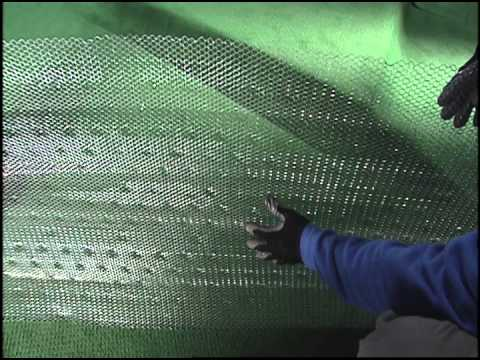

In [5]:
def play_one_vid(record_name, video_index):
    return vid_ids[video_index]
    
# this worked on my local jupyter notebook, but doesn't show on kaggle kernels:
YouTubeVideo(play_one_vid(video_lvl_record, 7))

In [6]:
print('mean_audio has length of: ')
print([len(x) for x in mean_audio][:5])
print('mean_rgb has length of: ')
print([len(x) for x in mean_rgb][:5])

mean_audio has length of: 
[128, 128, 128, 128, 128]
mean_rgb has length of: 
[1024, 1024, 1024, 1024, 1024]


In [7]:
# now, let's read the frame-level data
# due to execution time, we're only going to read the first video

feat_rgb = []
feat_audio = []

for example in tf.python_io.tf_record_iterator(frame_lvl_record):        
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        
        
    sess.close()
    feat_rgb.append(rgb_frame)
    feat_audio.append(audio_frame)
    break

In [8]:
print('The first video has %d frames' %len(feat_rgb[0]))


The first video has 300 frames


In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import numpy as np

In [13]:
n=10
from collections import Counter
label_mapping = pd.Series.from_csv('label_names.csv',header=0).to_dict()

top_n = Counter([item for sublist in labels for item in sublist]).most_common(n)
top_n_labels = [int(i[0]) for i in top_n]
top_n_label_names = [label_mapping[x] for x in top_n_labels]
top_n_label_names

['Games',
 'Vehicle',
 'Concert',
 'Video game',
 'Car',
 'Dance',
 'Musician',
 'Animation',
 'Football',
 'Food']

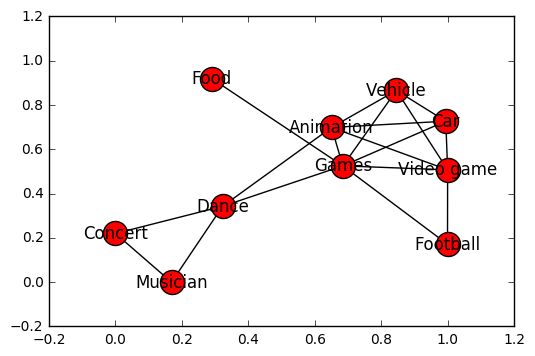

In [15]:
import networkx as nx
from itertools import combinations

G=nx.Graph()

G.clear()
for list_of_nodes in labels:
    filtered_nodes = set(list_of_nodes).intersection(set(top_n_labels))  
    for node1,node2 in list(combinations(filtered_nodes,2)): 
        node1_name = label_mapping[node1]
        node2_name = label_mapping[node2]
        G.add_node(node1_name)
        G.add_node(node2_name)
        G.add_edge(node1_name, node2_name)

nx.draw_networkx(G)


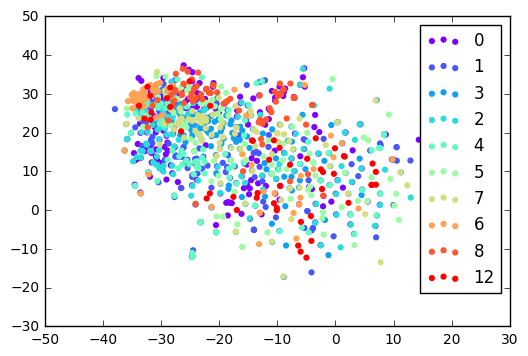

In [17]:
colors = plt.cm.rainbow(np.linspace(0, 1, n))
mean_rgb_top_n = []
labels_for_tsne = []
# filtering mean_rgb so it only contains top n labels
for idx, list_of_nodes in enumerate(labels):
    for node in list_of_nodes:
        if node in top_n_labels:
            mean_rgb_top_n.append(mean_rgb[idx])
            labels_for_tsne.append(node)


X_embedded = TSNE(n_components=2, random_state=0).fit_transform(mean_rgb_top_n) 


fig = plt.figure()
ax = fig.add_subplot(111)

handles = []
for indx, color in enumerate(colors):
    this_label = top_n_labels[indx]
    X_embedded_filtered = X_embedded[np.array([x==this_label for x in labels_for_tsne])]
    handles.append(ax.scatter(X_embedded_filtered[:, 0], X_embedded_filtered[:, 1], c=color, marker="o",edgecolor='none'))

ax.legend(handles, top_n_labels)

plt.show()